In [91]:
import numpy as np
import attocube.AMC as AMC

import time
AMC_IP = "192.168.1.78"
IP = AMC_IP

# Setup connection to AMC
amc = AMC.Device(IP)
amc.connect()

# Activate axis 1
# Internally, axes are numbered 0 to 2
axis = 1 # Axis 3
amc.control.setControlOutput(axis, True)

## Basic settings for OL movement


In [206]:
num_steps = 100
rate_slipstick = 4000E3 # [mHz],  from 1Hz to 5kHz
out_amp = 9E3 # [mV],  from 0 to 60V
out_offset = 0.0 # [mV] from 0 to 60V

amc.control.setControlFrequency(axis, rate_slipstick)
amc.move.writeNSteps(axis, num_steps)
num_steps = amc.move.getNSteps(axis)
amc.control.setControlAmplitude(axis, out_amp)
amc.control.setControlFixOutputVoltage(axis, out_offset)

rate_slipstick = amc.control.getControlFrequency(axis) # [mHz]
out_amp = amc.control.getControlAmplitude(axis)
# out_offset = amc.control.getControlFixOutputVoltage(axis)
out_offset = amc.control.getCurrentOutputVoltage(axis)
print(f"""
Number of step per trigger: {num_steps}
Slip-stick rate: {rate_slipstick/1000.0} Hz
Slip-stick amplitdue: {out_amp/1E3} V
DC Offset: {out_offset} mV
""")


Number of step per trigger: 100
Slip-stick rate: 3999.893 Hz
Slip-stick amplitdue: 8.998 V
DC Offset: 2999 mV



## Determine the forward and backward limits

In [207]:
# amc.status.getStatusEot(axis)
fwdlimit_reached = False
bkwdlimit_reached = False

while not fwdlimit_reached:
    amc.move.setControlContinuousFwd(axis, True)
    time.sleep(0.5)
    fwdlimit_reached = amc.status.getStatusEotFwd(axis)
    print(f"Forward limit reached?: {fwdlimit_reached}") # this can't be commented out!
    amc.move.setControlContinuousFwd(axis, False)
time.sleep(0.5)
x_fwdlimit = np.floor(amc.move.getPosition(axis))

while not bkwdlimit_reached:
    amc.move.setControlContinuousBkwd(axis, True)
    time.sleep(0.5)
    bkwdlimit_reached = amc.status.getStatusEotBkwd(axis)
    print(f"Backward limit reached?: {bkwdlimit_reached}") # this can't be commented out!
    amc.move.setControlContinuousBkwd(axis, False)
time.sleep(0.5)
x_bkwdlimit = np.ceil(amc.move.getPosition(axis))

x_cen = (x_fwdlimit-x_bkwdlimit)/2.0

print(f"""
X forward limit: {x_fwdlimit} nm
X backward limit: {x_bkwdlimit} nm
X center : {x_cen} nm
""")

Forward limit reached?: False
Forward limit reached?: False
Forward limit reached?: False
Forward limit reached?: False
Forward limit reached?: False
Forward limit reached?: False
Forward limit reached?: False
Forward limit reached?: False
Forward limit reached?: False
Forward limit reached?: False
Forward limit reached?: False
Forward limit reached?: False
Forward limit reached?: False
Forward limit reached?: True
Backward limit reached?: False
Backward limit reached?: False
Backward limit reached?: False
Backward limit reached?: False
Backward limit reached?: False
Backward limit reached?: False
Backward limit reached?: False
Backward limit reached?: False
Backward limit reached?: False
Backward limit reached?: False
Backward limit reached?: False
Backward limit reached?: False
Backward limit reached?: False
Backward limit reached?: False
Backward limit reached?: False
Backward limit reached?: True

X forward limit: 3265777.0 nm
X backward limit: 8185.0 nm
X center : 1628796.0 nm



## Determine movement per step

In [216]:
x_pos_listlist = []
for _ in range(10):
    backward = True
    amc.move.setControlTargetPosition(axis, x_fwdlimit) # move to the center
    amc.control.setControlMove(axis, True) 
    while not amc.status.getStatusTargetRange(axis):
        time.sleep(1.0)
    else:
        amc.control.setControlMove(axis, False)
    num_steps = 100
    amc.move.writeNSteps(axis, num_steps)
    num_steps = amc.move.getNSteps(axis)

    num_pulse = 100
    x_pos_list = np.zeros(num_pulse+1)

    while amc.status.getStatusMoving(axis):
            time.sleep(0.05)
    else:
        x_pos_list[0] = amc.move.getPosition(axis)
    sleeptime = max(2.0*num_steps/rate_slipstick*1000.0, 10E-3)
    for ii in range(num_pulse):
        amc.move.performNSteps(axis, backward)
        time.sleep(sleeptime)
        while amc.status.getStatusMoving(axis):
            time.sleep(sleeptime)
        else:
            x_pos_list[ii+1] = amc.move.getPosition(axis)

    x_pos_listlist += list(x_pos_list)
# x_moved = amc.move.getPosition(axis) - x_pos_list[0]

# dx_perstep = x_moved/(num_pulse*num_steps)
# print(f"""
# Steps per pulse: {num_steps}
# # Number of pulses: {num_pulse}
# Steps moved: {num_pulse*num_steps} 
# dx per step: {dx_perstep} nm
# """)
# # x_list = np.arange()


In [217]:
x_pos_listlist = np.array(x_pos_listlist)

In [218]:

from scipy.ndimage import shift
dx_listlist = []

xpll = np.reshape(x_pos_listlist, (int(len(x_pos_listlist)/(num_pulse+1)), num_pulse+1))
for x_pos_list in xpll:
    dx_list = x_pos_list[1:] - shift(x_pos_list, 1, cval=np.NaN)[1:]
    dx_listlist += list(dx_list)

dx_list = np.array(dx_listlist)

In [219]:
dx_sd = np.std(dx_list)
dx_mean = np.mean(dx_list)
print(f"{dx_mean}, {dx_sd}")

-9486.453841000477, 6143.532738353254


(array([  2.,   4.,   6.,  15.,  20.,  41.,  60., 115., 199., 221., 205.,
         66.,  33.,   8.,   5.]),
 array([-36157.497     , -33176.94553333, -30196.39406667, -27215.8426    ,
        -24235.29113333, -21254.73966667, -18274.1882    , -15293.63673333,
        -12313.08526667,  -9332.5338    ,  -6351.98233333,  -3371.43086667,
          -390.8794    ,   2589.67206667,   5570.22353333,   8550.775     ]),
 <BarContainer object of 15 artists>)

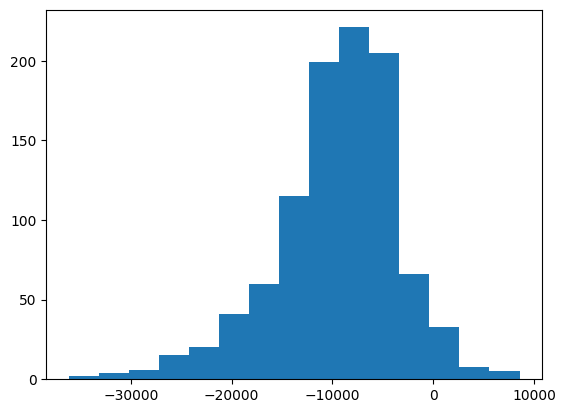

In [220]:
import matplotlib.pyplot as plt
counts, bins = np.histogram(dx_list, bins=15, range=None, density=None, weights=None)
plt.hist(bins[:-1], bins, weights=counts)

## 

In [199]:
# amc.control.getControlAmplitude(axis)
amc.control.getPositionsAndVoltages()

(2397969.636,
 1594764.15,
 924603.937,
 2999.9980273246765,
 2999.9980273246765,
 2999.9980273246765)

## Turn off control output and close connection

In [ ]:
# Deativate axis
amc.control.setControlOutput(axis, False)

# Close connection
amc.close()